In [9]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pickle

def load_data():
    # Specify the file paths for the CIFAR-10 dataset
    data_dir = "cifar-10"
    train_files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]
    test_file = "test_batch"
    meta_file = "batches.meta"

    # Function to load a single CIFAR-10 batch file
    def load_cifar_batch(file_path):
        with open(file_path, 'rb') as fo:
            batch_dict = pickle.load(fo, encoding='bytes')
        images = batch_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        labels = np.array(batch_dict[b'labels'])
        return images, labels

    # Load training data
    train_images = []
    train_labels = []
    for train_file in train_files:
        file_path = f"{data_dir}/{train_file}"
        images, labels = load_cifar_batch(file_path)
        train_images.append(images)
        train_labels.append(labels)

    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)

    # Load test data
    test_file_path = f"{data_dir}/{test_file}"
    test_images, test_labels = load_cifar_batch(test_file_path)

    # Load label names
    meta_file_path = f"{data_dir}/{meta_file}"
    with open(meta_file_path, 'rb') as fo:
        label_names = pickle.load(fo, encoding='bytes')[b'label_names']
    
    return train_images, train_labels, test_images, test_labels


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 1, 3072)      30720       ['input_50[0][0]']               
                                                                                                  
 input_49 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 reshape_16 (Reshape)           (None, 32, 32, 3)    0           ['embedding_15[0][0]']           
                                                                                           

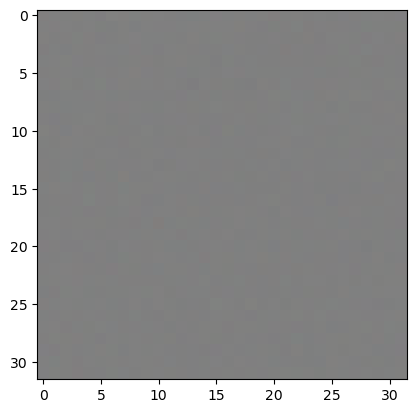

ValueError: in user code:

    File "e:\Users\AbbasMn\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "e:\Users\AbbasMn\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\Users\AbbasMn\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "e:\Users\AbbasMn\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "e:\Users\AbbasMn\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'reshape_16' (type Reshape).
    
    Cannot reshape a tensor with 983040 elements to shape [32,32,32,3] (98304 elements) for '{{node model_22/reshape_16/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](model_22/embedding_15/embedding_lookup/Identity_1, model_22/reshape_16/Reshape/shape)' with input shapes: [32,10,3072], [4] and with input tensors computed as partial shapes: input[1] = [32,32,32,3].
    
    Call arguments received by layer 'reshape_16' (type Reshape):
      • inputs=tf.Tensor(shape=(32, 10, 3072), dtype=float32)


In [13]:
# AC-GAN generator
def build_generator(latent_dim, num_classes):
    generator_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    merged_input = layers.multiply([generator_input, label_embedding])

    x = layers.Dense(256)(merged_input)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(512)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(3072, activation='tanh')(x)
    x = layers.Reshape((32, 32, 3))(x)

    generator = keras.models.Model([generator_input, label_input], x)
    return generator

# AC-GAN discriminator
def build_discriminator(num_classes):
    discriminator_input = layers.Input(shape=(32, 32, 3))
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 32 * 32 * 3)(label_input)
    flat_embedding = layers.Reshape((32, 32, 3))(label_embedding)
    merged_input = layers.concatenate([discriminator_input, flat_embedding])

    x = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(merged_input)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU()(x)

    discriminator_output = layers.Dense(1, activation='sigmoid')(x)

    discriminator = keras.models.Model([discriminator_input, label_input], discriminator_output)
    discriminator.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return discriminator

# AC-GAN combined model
def build_acgan(generator, discriminator):
    generator_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,))
    generated_image = generator([generator_input, label_input])
    discriminator_output = discriminator([generated_image, label_input])

    acgan = keras.models.Model([generator_input, label_input], discriminator_output)
    acgan.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return acgan

# Training the AC-GAN
latent_dim = 100
num_classes = 10

# Load and preprocess the CIFAR-10 dataset
# (x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train, y_train, x_test, y_test = load_data()
x_train = x_train.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, num_classes)

# Build and compile the discriminator
discriminator = build_discriminator(num_classes)
discriminator.trainable = False
discriminator.summary()

# Build the generator
generator = build_generator(latent_dim, num_classes)
generator.summary()

# Build and compile the AC-GAN
acgan = build_acgan(generator, discriminator)

def img_to_uint8(img):
    return np.uint8(img*127.5+128).clip(0, 255)

# Training loop
epochs = 200
batch_size = 32

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for batch in range(len(x_train) // batch_size):
        # Training the discriminator
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
        generated_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        generated_images = generator.predict([random_latent_vectors, generated_labels])

        real_images = x_train[batch * batch_size: (batch + 1) * batch_size]
        real_labels = y_train[batch * batch_size: (batch + 1) * batch_size]
        plt.imshow(img_to_uint8(generated_images[0]))
        plt.show()

        discriminator_loss_real = discriminator.train_on_batch([real_images, real_labels], np.ones((batch_size, 1)))
        discriminator_loss_fake = discriminator.train_on_batch([generated_images, generated_labels], np.zeros((batch_size, 1)))
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

        # Training the generator
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
        generated_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        acgan_loss = acgan.train_on_batch([random_latent_vectors, generated_labels], np.ones((batch_size, 1)))

        print(f"Batch {batch+1}/{len(x_train) // batch_size} | D loss: {discriminator_loss[0]:.4f}, G loss: {acgan_loss[0]:.4f}")


In [7]:
def build_generator(latent_dim, num_classes):
    generator_input = keras.Input(shape=(latent_dim,))
    label_input = keras.Input(shape=(num_classes,))
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    merged_input = layers.multiply([generator_input, label_embedding])

    x = layers.Dense(128 * 8 * 8)(merged_input)
    x = layers.Reshape((8, 8, 128))(x)

    x = layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(512, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(3, kernel_size=(3, 3), padding='same', activation='tanh')(x)

    generator = keras.models.Model([generator_input, label_input], x)
    return generator


def build_discriminator(num_classes):
    discriminator_input = keras.Input(shape=(32, 32, 3))
    label_input = keras.Input(shape=(num_classes,))
    label_embedding = layers.Embedding(num_classes, 32 * 32 * 3)(label_input)
    flat_embedding = layers.Reshape((32, 32, 3))(label_embedding)
    merged_input = layers.concatenate([discriminator_input, flat_embedding])

    x = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(merged_input)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU()(x)

    discriminator_output = layers.Dense(1, activation='sigmoid')(x)

    discriminator = keras.models.Model([discriminator_input, label_input], discriminator_output)
    discriminator.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return discriminator

def build_acgan(generator, discriminator):
    discriminator.trainable = False
    acgan_input = keras.Input(shape=(latent_dim,))
    acgan_label = keras.Input(shape=(num_classes,))
    generated_image = generator([acgan_input, acgan_label])
    acgan_output = discriminator([generated_image, acgan_label])
    
    acgan = keras.models.Model([acgan_input, acgan_label], acgan_output)
    acgan.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return acgan

# Load and preprocess the CIFAR-10 dataset
# (x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train, y_train, x_test, y_test = load_data()
x_train = x_train.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, num_classes)

latent_dim = 100
num_classes = 10

generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(num_classes)
acgan = build_acgan(generator, discriminator)

# Training the AC-GAN
epochs = 200
batch_size = 64

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for batch in range(len(x_train) // batch_size):
        # Training the discriminator
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
        generated_labels = np.random.randint(0, num_classes, batch_size)
        generated_labels = keras.utils.to_categorical(generated_labels, num_classes)  # Convert to one-hot encoding
        generated_images = generator.predict([random_latent_vectors, generated_labels])

        real_images = x_train[batch * batch_size: (batch + 1) * batch_size]
        real_labels = y_train[batch * batch_size: (batch + 1) * batch_size]
        print(real_images.shape)

        discriminator_labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        discriminator_loss = discriminator.train_on_batch(
            [np.concatenate([real_images, generated_images]), np.concatenate([real_labels, generated_labels])],
            discriminator_labels
        )

        # Training the generator
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
        generated_labels = np.random.randint(0, num_classes, batch_size)
        generated_labels = keras.utils.to_categorical(generated_labels, num_classes)  # Convert to one-hot encoding

        acgan_loss = acgan.train_on_batch([random_latent_vectors, generated_labels], np.ones((batch_size, 1)))

        print(f"Batch {batch+1}/{len(x_train) // batch_size} | D loss: {discriminator_loss[0]:.4f}, G loss: {acgan_loss[0]:.4f}")


ValueError: Exception encountered when calling layer "reshape_8" (type Reshape).

total size of new array must be unchanged, input_shape = [10, 8192], output_shape = [8, 8, 128]

Call arguments received by layer "reshape_8" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 10, 8192), dtype=float32)

In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Load CIFAR-10 dataset
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Normalize input images
x_train = (x_train - 127.5) / 127.5
y_train = keras.utils.to_categorical(y_train, num_classes=10)

# Generator
latent_dim = 100

generator_inputs = keras.Input(shape=(latent_dim,))
generator_labels = keras.Input(shape=(10,))
generator_input = layers.Concatenate()([generator_inputs, generator_labels])

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding="same", activation="tanh")(x)

generator = keras.models.Model([generator_inputs, generator_labels], x)
generator.summary()

# Discriminator
discriminator_inputs = keras.Input(shape=(32, 32, 3))
discriminator_labels = keras.Input(shape=(10,))
discriminator_input = layers.Concatenate()([discriminator_inputs, discriminator_labels])

x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(discriminator_input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation="sigmoid")(x)

discriminator = keras.models.Model([discriminator_inputs, discriminator_labels], x)
discriminator.summary()

# Compile discriminator
discriminator.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=["accuracy"])

# GAN
discriminator.trainable = False
gan_inputs = keras.Input(shape=(latent_dim,))
gan_labels = keras.Input(shape=(10,))
gan_output = discriminator([generator([gan_inputs, gan_labels]), gan_labels])

gan = keras.models.Model([gan_inputs, gan_labels], gan_output)
gan.summary()

# Compile GAN
gan.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

# Training loop
epochs = 20000
batch_size = 128

for epoch in range(epochs):
    # Train discriminator
    random_indices = np.random.randint(0, x_train.shape[0], size=batch_size)
    real_images = x_train[random_indices]
    real_labels = y_train[random_indices]

    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    generated_images = generator.predict([noise, real_labels])

    labels = np.concatenate([real_labels, real_labels])
    images = np.concatenate([real_images, generated_images])
    labels_noise = np.concatenate([real_labels, real_labels])
    images_noise = np.concatenate([generated_images, generated_images])

    labels_noise[np.arange(batch_size), np.random.randint(0, 10, size=batch_size)] = 1

    d_loss_real = discriminator.train_on_batch([images, labels], np.ones((2 * batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([images_noise, labels_noise], np.zeros((2 * batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    labels = keras.utils.to_categorical(np.random.randint(0, 10, batch_size), num_classes=10)

    g_loss = gan.train_on_batch([noise, labels], np.ones((batch_size, 1)))

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Discriminator Loss: {d_loss[0]:.4f} | Discriminator Accuracy: {d_loss[1]*100:.2f}% | Generator Loss: {g_loss:.4f}")

# Generate images
num_samples = 10
noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
labels = keras.utils.to_categorical(np.arange(0, 10), num_classes=10)
generated_images = generator.predict([noise, labels])

# Denormalize images
generated_images = (generated_images * 127.5) + 127.5

# Display generated images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, num_samples, figsize=(num_samples, 1))
fig.suptitle("Generated Images")

for i in range(num_samples):
    axs[i].imshow(generated_images[i].astype(np.uint8))
    axs[i].axis("off")

plt.show()


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 concatenate_7 (Concatenate)    (None, 110)          0           ['input_45[0][0]',               
                                                                  'input_46[0][0]']               
                                                                                                  
 dense_43 (Dense)               (None, 32768)        3637248     ['concatenate_7[0][0]']   

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 32, 32, 3), (None, 10)]